## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [3]:
df = pd.read_csv("data_cleaned.csv")

In [4]:
df.shape

(10663, 20)

In [5]:
df.head(2)

,Unnamed: 0,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,0,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,1,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [10]:
df.drop(columns = ['Unnamed: 0', 'team', 'name', 'position'], inplace = True)

In [11]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [12]:
# Completeness
df.isnull().sum()

height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [13]:
# Accurecy types
df.dtypes

height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
dtype: object

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [14]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000


In [16]:
df.columns

Index(['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
       'second yellow cards', 'red cards', 'goals conceded', 'clean sheets',
       'minutes played', 'days_injured', 'games_injured', 'award',
       'current_value', 'highest_value'],
      dtype='object')

In [17]:
numeric_features = [ 'height', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
       'second yellow cards', 'red cards', 'goals conceded', 'clean sheets',
       'minutes played', 'days_injured', 'games_injured', 'award',
       'current_value', 'highest_value']

In [19]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Value'
    elif price < p75:
        return 'Good_Value'
    else:
        return 'High_Value'

# Apply the function to create a new column
df['current_value_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['current_value_category'].value_counts())

Good_Value     4279
Cheap_Value    3668
High_Value     2672
Name: current_value_category, dtype: int64


In [28]:
encoder = LabelEncoder()
df['current_value_category_encoded'] = encoder.fit_transform(df['current_value_category'])  

In [ ]:
correlation = df.corr(numeric_only=True)
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

In [ ]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value_category_encoded']) > \
threshold]['current_value_category_encoded'].index
selected_features

In [ ]:
selected_features = ['age', 'appearance', 'minutes played', 'highest_value',
       'current_value_category_encoded']

In [ ]:
# Prepare data
X = df.drop(['current_value_category_encoded'], axis=1)
y = df['current_value_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Buliding the Model

In [23]:
model = KNeighborsClassifier()

In [24]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [100]:
grid_search.best_params_

{'n_neighbors': 5}

In [ ]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

In [101]:
model = grid_search.best_estimator_

## Test the Model

In [102]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [103]:
# our benchmark model
base_model = round(df['current_value_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

39.99

1. Accuracy

In [46]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7411095305832148

In [47]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.8141025641025641

In [48]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[186,  52,   5],
       [ 55, 192,  33],
       [  4,  33, 143]])

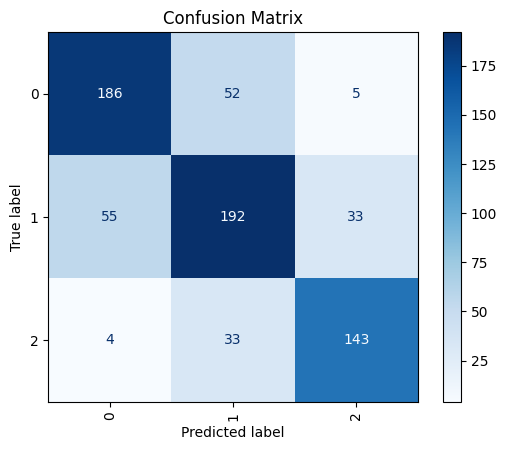

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [50]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.75


In [51]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.75


In [52]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.75


In [54]:
# from sklearn.inspection import DecisionBoundaryDisplay
 
# # Plot Decision Boundary
# DecisionBoundaryDisplay.from_estimator(
#         model,
#         X_train,
#         response_method="predict",
#         cmap=plt.cm.Spectral,
#         alpha=0.8,
#     )
 
# # Scatter plot
# plt.scatter(X[:, 0], X[:, 1], 
#             c=y, 
#             s=20, edgecolors="k")
# plt.show()

In [108]:
import joblib
joblib.dump(model, 'Models/knn_model.joblib')
joblib.dump(scaler, 'Models/scaler.joblib')

['Models/scaler.joblib']